# FASTER R-CNN

In [1]:
# imports
import numpy as np
import tensorflow as tf

In [11]:
#Feature Extraction
# create random image
image = np.zeros((1,3,800,800))
#change type to float
image = image.astype(np.float32)
# convert to tensor
image = tf.convert_to_tensor(image)

In [28]:
# Using just tensorflow to create generic data of ...
# image
image = tf.zeros([1,800,800,3], tf.float32)
# bbox
bbox = tf.constant([[20, 30, 400, 500], [300, 400, 500, 600]])
# labels for each bbox
labels = tf.constant([6,8]) 
sub_sample = 16

The VGG16 network is used as a feature extraction module here, This acts as a backbone for both the RPN network and Fast_R-CNN network. We need to make a few changes to the VGG network inorder to make this work. Since the input of the network is 800, the output of the feature extraction module should have a feature map size of (800//16). So we need to check where the VGG16 module is achieving this feature map size and trim the network till der. This can be done in the following way.

#### Pytorch implementation:
https://medium.com/@fractaldle/guide-to-build-faster-rcnn-in-pytorch-95b10c273439

## 1 ) VGG16  import

In [63]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
import tensorflow.keras.layers as layers

In [23]:
# The default input size for this model is 224x224.
vgg = VGG16(weights='imagenet', include_top=False, input_tensor=layers.Input(shape=[800, 800, 3]))

58892288/58889256 [==============================] - 11s 0us/step


In [24]:
vgg.trainable = False

In [59]:
#Show the layers
vgg.layers
# or uncomment the next line
#vgg.summary()

In [46]:
#how to pass a input test tensor through the layers without compile the model?
im = image
fe_layers = vgg.layers
l_c = 0
req_layers = []
print("size of vgg feature layers: ", len(fe_layers))
# Use CPU to test the convolutions
with tf.device('CPU:0'):
    for i in fe_layers:
        im = i(im)
        if im.shape[1] < 800//16:
            print('brake')
            break
        req_layers.append(i)
        l_c += 1
        out_channels = im.shape
print('shape of ouput: ', out_channels)
print('number of layers needed: ', l_c)

size of vgg feature layers:  19
brake
shape of ouput:  (1, 50, 50, 512)
number of layers needed:  18


In [47]:
# print the required layers
print(req_layers)

[<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000001EE5787D388>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001EE5787DD08>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001EE57848DC8>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001EE579EA1C8>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001EE579DF608>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001EE579F3148>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001EE579E6AC8>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001EE57A06408>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001EE57A15D48>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001EE57A17A48>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001EE57A21248>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001EE

In [60]:
# create the bakcbone for fast r-cnn
input_fe = layers.Input(shape=[800, 800, 3])
fe_extractor = req_layers[1](input_fe)
for l in range(2,len(req_layers)):
    fe_extractor = req_layers[l](fe_extractor)

In [70]:
# Test feature extractor model output
fe_model = Model(inputs=input_fe, outputs=fe_extractor)
im = image
with tf.device('CPU:0'):
    im = fe_model(im)
print("shape of output: ",im.shape)
del(fe_model)

# Input = input_fe,
# Output of extractor feature = fe_extractor

shape of output:  (1, 50, 50, 512)


## 2) Anchor boxes

In [57]:
%matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

Using matplotlib backend: Qt5Agg


We will use anchor_scales of 8, 16, 32, ratio of 0.5, 1, 2 and sub sampling of 16 (Since we have pooled our image from 800 px to 50px). Now every pixel in the output feature map maps to corresponding 16 * 16 pixels in the image.

At each pixel location on the feature map, We need to generate 9 anchor boxes (number of anchor_scales and number of ratios) and each anchor box will have ‘y1’, ‘x1’, ‘y2’, ‘x2’. So at each location anchor will have a shape of (9, 4). 

In [2]:
# As an example will be created 9 anchor boxes space for 'y1', 'x1', 'y2', 'x2'
ratios = [0.5, 1, 2]
# 0.5 : ratio 2:1; 1 : ratio 1:1; 2 : ratio 1:2;
anchor_scales = [8, 16, 32]
anchor_base = np.zeros((len(ratios)*len(anchor_scales), 4), dtype=np.float32)

print(anchor_base)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [5]:
# example to fill the anchor x and y coordinates values for the 9 anchor boxes of the respective size and ratio
sub_sample = 16
ctr_y = sub_sample / 2.
ctr_x = sub_sample / 2.

print('center of the sample anchor boxes: yc = {}, xc = {}'.format(ctr_y, ctr_x))
for i in range(len(ratios)):
    for j in range(len(anchor_scales)):
        h = sub_sample * anchor_scales[j] * np.sqrt(ratios[i])
        w = sub_sample * anchor_scales[j] * np.sqrt(1./ ratios[i])
        #print("height: {}, width: {}".format(h, w))
        
        index = i * len(anchor_scales) + j
        
        anchor_base[index, 0] = ctr_y - h/ 2.
        anchor_base[index, 1] = ctr_x - w/ 2.
        anchor_base[index, 2] = ctr_y + h/ 2.
        anchor_base[index, 3] = ctr_x + w/ 2.

print(anchor_base)

center of the sample anchor boxes: yc = 8.0, xc = 8.0
[[ -37.254833  -82.50967    53.254833   98.50967 ]
 [ -82.50967  -173.01933    98.50967   189.01933 ]
 [-173.01933  -354.03867   189.01933   370.03867 ]
 [ -56.        -56.         72.         72.      ]
 [-120.       -120.        136.        136.      ]
 [-248.       -248.        264.        264.      ]
 [ -82.50967   -37.254833   98.50967    53.254833]
 [-173.01933   -82.50967   189.01933    98.50967 ]
 [-354.03867  -173.01933   370.03867   189.01933 ]]


These are the anchor locations at the first feature map pixel, we have to now generate these anchors at all the locations of feature map. 

In the later section we will label them with -1 and remove them when calculating the loss the functions and generating proposals for anchor boxes.

Also Since we got 9 anchors at each location and there 50 * 50 such locations inside an image, We will get 17500 ((50 * 50 * 9) - (number of invalid anchor boxes)) anchors in total.

### Generate anchors for all the feature map (50 x 50 x 512) 

In [8]:
fe_size = (800//16)
ctr_x = np.arange(16, (fe_size+1) * 16, 16)
ctr_y = np.arange(16, (fe_size+1) * 16, 16)

ctr_x

array([ 16,  32,  48,  64,  80,  96, 112, 128, 144, 160, 176, 192, 208,
       224, 240, 256, 272, 288, 304, 320, 336, 352, 368, 384, 400, 416,
       432, 448, 464, 480, 496, 512, 528, 544, 560, 576, 592, 608, 624,
       640, 656, 672, 688, 704, 720, 736, 752, 768, 784, 800])

In [27]:
# Generate the center coordinates for every anchor box
index = 0
ctr = []
#print(ctr[0][1])
for x in range(len(ctr_x)):
    for y in range(len(ctr_y)):
        #print(index)
        ctr.append([ctr_y[y] - 8 , ctr_x[x] - 8])
        index += 1
ctr = np.array(ctr)

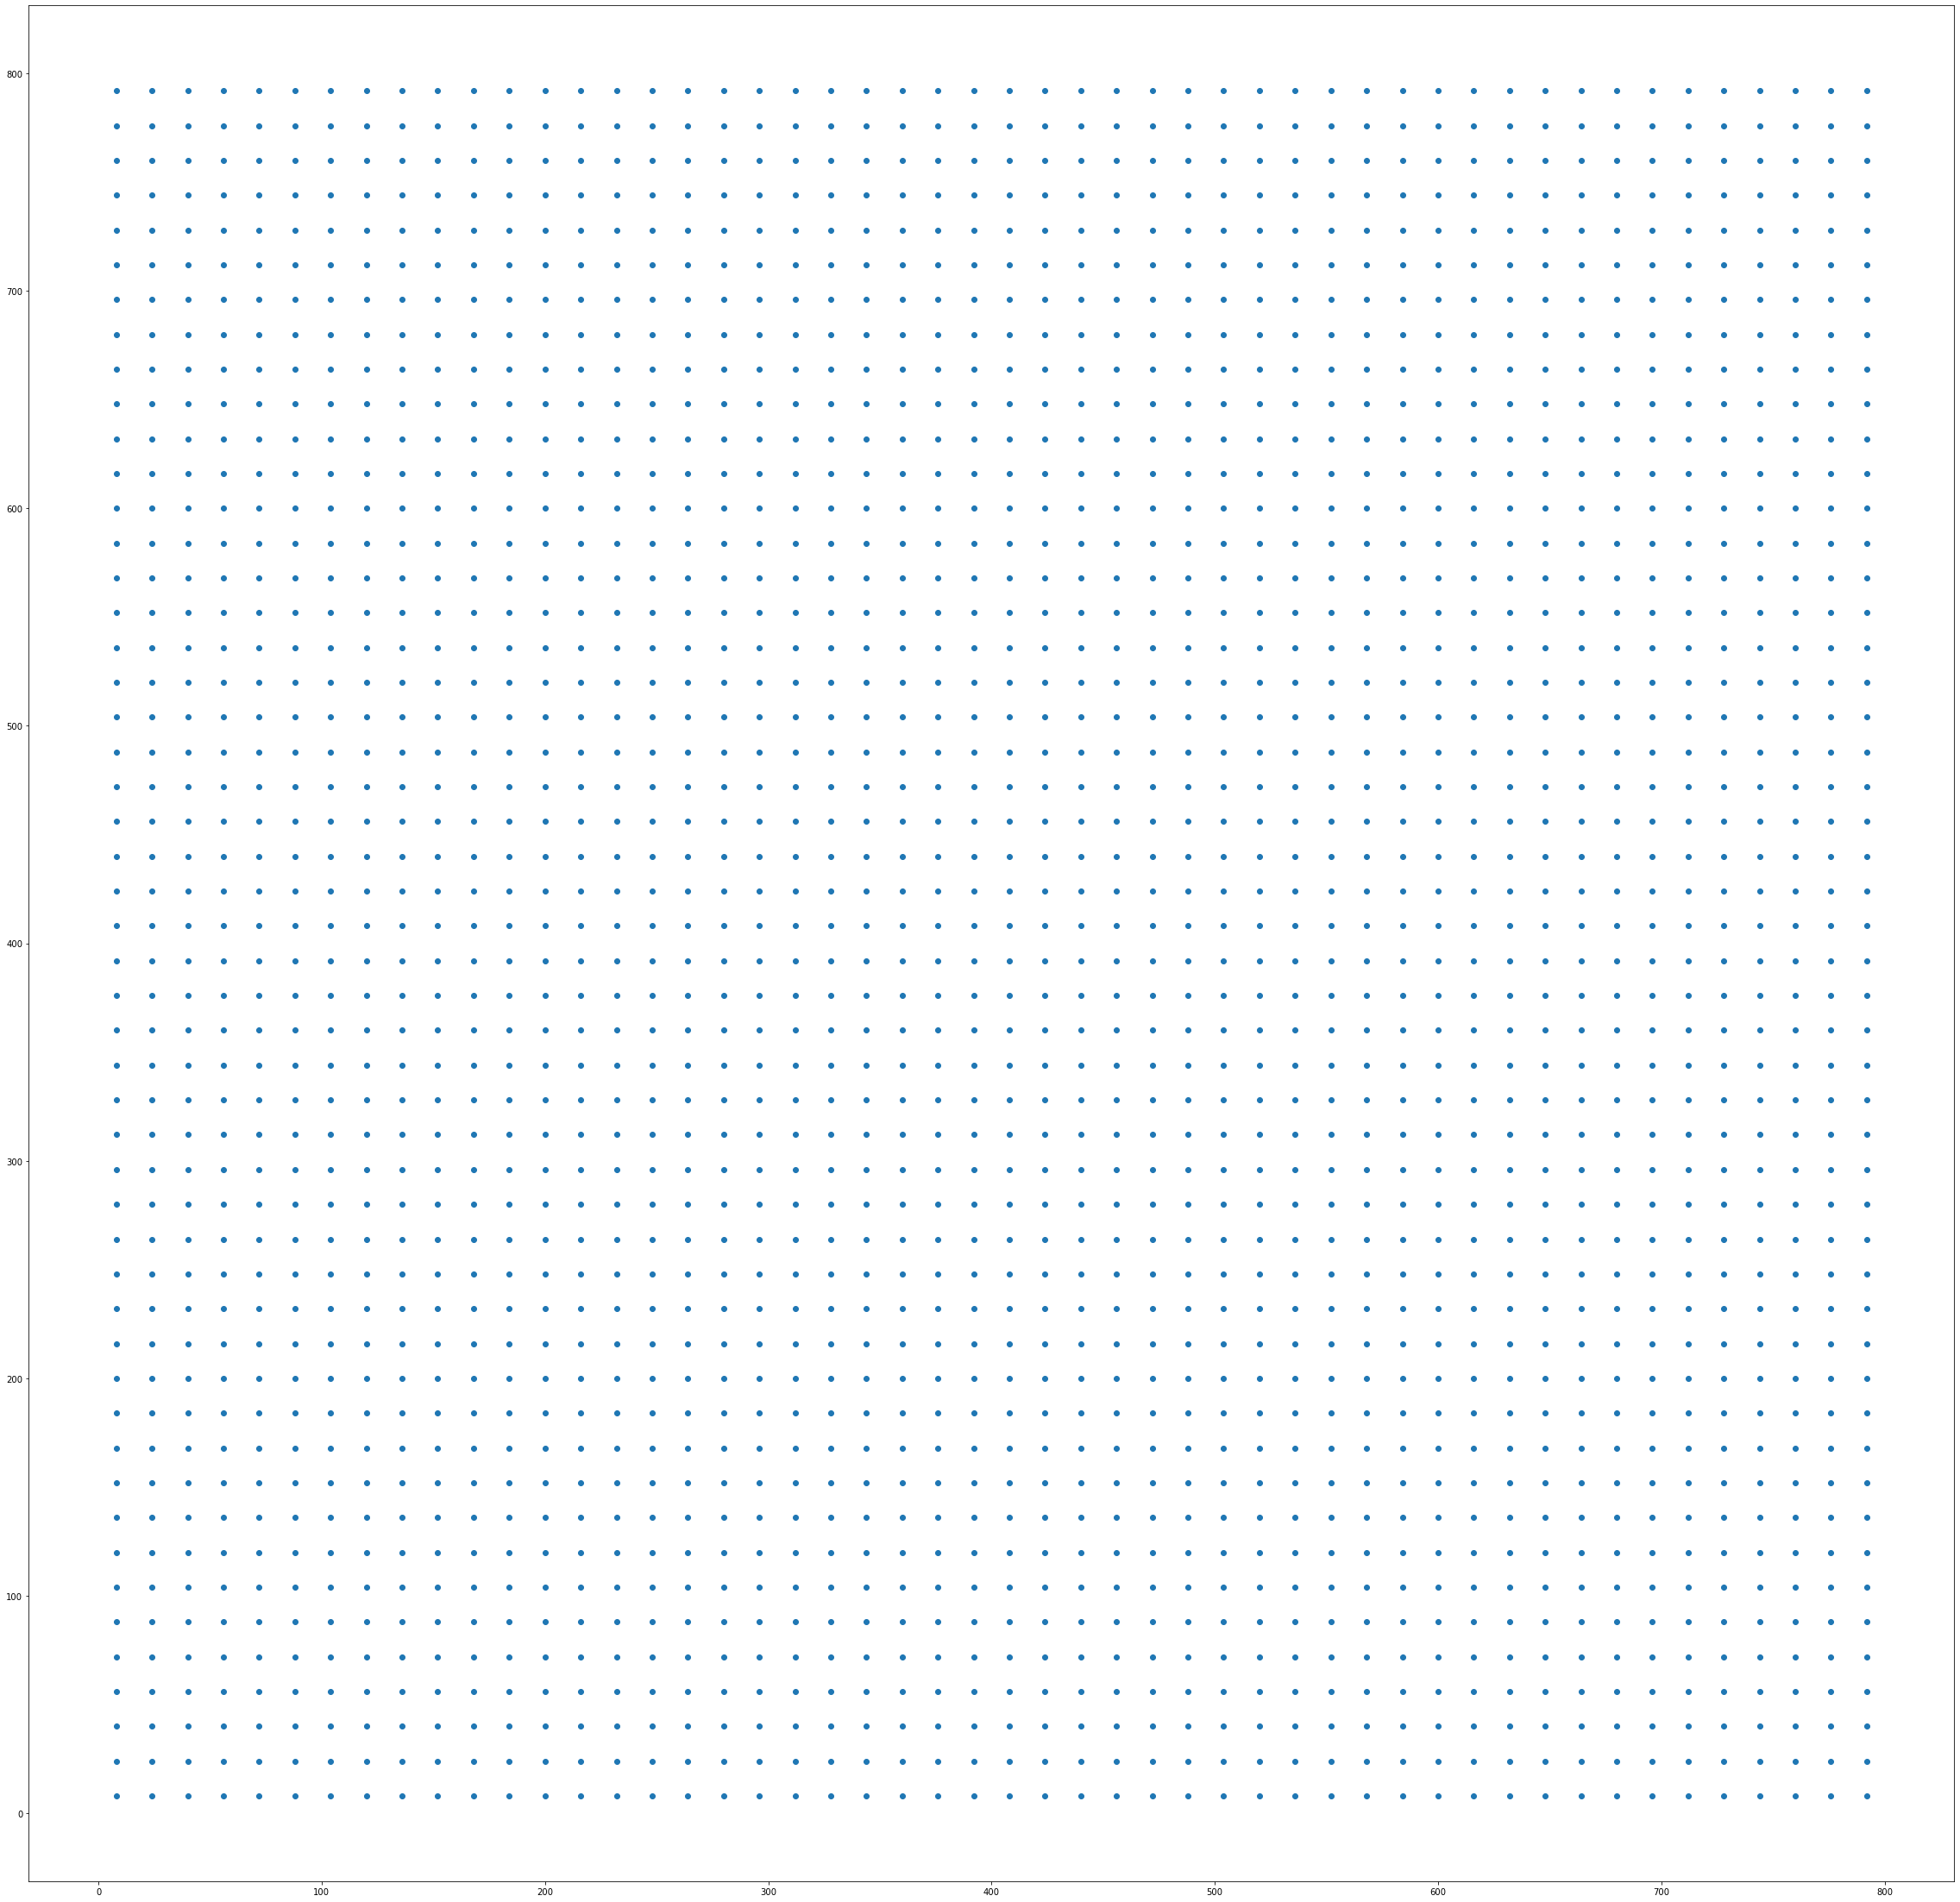

In [36]:
# Plot the center of the anchor boxes
plt.figure(figsize=(40,40))
plt.scatter(ctr[:,1],ctr[:,0])
plt.show()

The output will be the (x, y) value at each location as shown in the image above. Together we have 2500 anchor centers. Now at each center we need to generate the anchor boxes. This can be done using the code we have used for generating anchor at one location, adding an extract for loop for supplying centers of each anchor will do. Lets see how this is done


In [40]:
# Create the 9 anchor box for every center
anchors = np.zeros(((fe_size*fe_size*9), 4))
index = 0
for c in ctr:
    ctr_y, ctr_x = c
    for i in range(len(ratios)):
        for j in range(len(anchor_scales)):
            h = sub_sample * anchor_scales[j] * np.sqrt(ratios[i])
            w = sub_sample * anchor_scales[j] * np.sqrt(1./ ratios[i])
            
            anchors[index, 0] = ctr_y - h/ 2.
            anchors[index, 1] = ctr_x - w/ 2.
            anchors[index, 2] = ctr_y + h/ 2.
            anchors[index, 3] = ctr_x + w/ 2.
            index += 1
            
print(anchors.shape)

(22500, 4)


There are better way of generating anchor boxes

In [61]:
# Get just the valid indexes of the anchor boxes
index_inside = np.where((
    (anchors[:, 0] >= 0) &
    (anchors[:, 1] >= 0) &
    (anchors[:, 2] <= 800) &
    (anchors[:, 3] <= 800)
    ))[0]
print(index_inside.shape)

(8940,)


In [65]:
# create an empty array with inside_index shape and fill with -1
label = np.empty((len(index_inside), ), dtype=np.int32)
label.fill(-1)
print("label shape: {}".format(label.shape))

# array with valid anchors
valid_anchor_boxes = anchors[index_inside]
print("valid anchor boxes: {}".format(valid_anchor_boxes.shape))

label shape: (8940,)
valid anchor boxes: (8940, 4)


### IOU calculation for every anchor box

In [66]:
# Example of ground truth bbox and labels
bbox = np.asarray([[20, 30, 400, 500],[300, 400, 500, 600]], dtype=np.float32)
# labels of the bbox
labels = np.asarray([6,8], dtype=np.int8)
# 0 represent background

$IOU = \frac{A \cap B}{A \cup B}$

A = Area of ground truth;

B = Area of anchor box;

$IOU = \frac{Area of intersection}{Area of ground truth + Area of anchor - Area of intersection}$

In [69]:
# Create array of iou ( intersection over union) of every anchor box
ious = np.empty((len(valid_anchor_boxes), len(bbox)), dtype=np.float32)
ious.fill(0)
for num1, i in enumerate(valid_anchor_boxes):
    #num1 = enumeration of anchor
    #i = anchor box [y1, x1, y2, x2]
    ya1, xa1, ya2, xa2 = i
    anchor_area = (ya2 - ya1) * (xa2 - xa1)
    for num2, j in enumerate(bbox):
        #num2 = enumeration of bbox with ground truth
        #j = bbox with ground truth
        yb1, xb1, yb2, xb2 = j
        box_area = (yb2 - yb1) * (xb2 - xb1)
        
        inter_x1 = max([xb1, xa1])
        inter_y1 = max([yb1, ya1])
        inter_x2 = min([xb2, xa2])
        inter_y2 = min([yb2, ya2])
        
        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            iter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
            iou = iter_area / (anchor_area + box_area - iter_area)
        else:
            iou = 0.
        ious[num1, num2] = iou

print("ious shape: {}".format(ious.shape))

ious shape: (8940, 2)


Note: Using numpy arrays, these calculations can be done much more efficiently and with less verbose.

Now since we have generated all the anchor boxes, we need to look at the objects inside the image and assign them to the specific anchor boxes which contain them. Faster_R-CNN has some guidelines to assign labels to the anchor boxes
We assign a positive label to two kind of anchors 

a) The anchor/anchors with the highest Intersection-over-Union(IoU) overlap with a ground-truth-box or 

b) An anchor that has an IoU overlap higher than 0.7 with ground-truth box.
Note that single ground-truth object may assign positive labels to multiple anchors.

c) We assign a negative label to a non-positive anchor if its IoU ratio is lower than 0.3 for all ground-truth boxes. 

d) Anchors that are neither positive nor negitive do not contribute to the training objective.

In [71]:
# a) get the index of the greatest IOU for each ground truth bbox
# indexes
gt_argmax_ious = ious.argmax(axis=0)
print(gt_argmax_ious)

# IOU value
gt_max_ious = ious[gt_argmax_ious, np.arange(ious.shape[1])]
print(gt_max_ious)

[2262 5620]
[0.68130493 0.61035156]


In [74]:
# b) get the greater value between the IOUs of every valid anchor box

# get the localization of the greater value of IOU of every anchor
argmax_ious = ious.argmax(axis=1)
print(argmax_ious.shape)
print(argmax_ious)

# get the value of the greater value of IOU of every valid anchor box
max_ious = ious[np.arange(len(index_inside)), argmax_ious]
print(max_ious)

(8940,)
[0 0 0 ... 0 0 0]
[0.06811669 0.07083762 0.07083762 ... 0.         0.         0.        ]


In [75]:
# find the anchor boxes which have this max_ious(gt_max_ious)

gt_argmax_ious = np.where(ious == gt_max_ious)[0]
print(gt_argmax_ious)

[2262 2508 5620 5628 5636 5644 5866 5874 5882 5890 6112 6120 6128 6136
 6358 6366 6374 6382]


Now we have three arrays

argmax_ious — Tells which ground truth object has max iou with each anchor.

max_ious — Tells the max_iou with ground truth object with each anchor.

gt_argmax_ious — Tells the anchors with the highest Intersection-over-Union (IoU) overlap with a ground-truth box.

Using argmax_ious and max_ious we can assign labels and locations to anchor boxes which satisify [b] and [c]. Using gt_argmax_ious we can assign labels and locations to anchor boxes which satisify [a].

### Asign Label to anchor boxes

In [76]:
pos_iou_threshold = 0.7
neg_iou_threshold = 0.3

In [77]:
# label array initialized with "-1" value 
label
# -1 : No used for training
# 0 : No object in the anchor; it is applied if the max_ious[i] < neg_iou_threshold
# 1 : Object in the anchor; it is applied if the max_ious[i] >= pos_iou_threshold ...
# or if the anchor is one of the gt_argmax_ious

array([-1, -1, -1, ..., -1, -1, -1])

In [79]:
# no object in anchor
label[max_ious < neg_iou_threshold] = 0
# object in anchor
label[gt_argmax_ious] = 1
label[max_ious >= pos_iou_threshold] = 1

### Selection of the training anchor boxes

Training RPN The Faster_R-CNN paper phrases as follows Each mini-batch arises from a single image that contains many positive and negitive example anchors, but this will bias towards negitive samples as they are dominate. Instead, we randomly sample 256 anchors in an image to compute the loss function of a mini-batch, where the sampled positive and negative anchors have a ratio of up to 1:1. If there are fewer than 128 positive samples in an image, we pad the mini-batch with negitive ones

In [80]:
# Since it is needed 256 anchors to compute the loss function with equal negative and positive samples
# it is defined the next:
pos_ratio = 0.5
n_sample = 256
# Total of positive samples
n_pos = pos_ratio * n_sample

In [83]:
# Positive samples:

pos_index = np.where(label == 1)[0]
 # if there are more than n_pos positive samples, some of them are disabled the get just n_pos samples
if len(pos_index) > n_pos:
    disable_index = np.random.choice(pos_index, size=(len(pos_index) - n_pos), replace=False)
    label[disable_index] = -1

In [84]:
# Negative samples:

# Check this line after: n_neg = n_sample * np.sum(label == 1)
n_neg = n_sample - np.sum(label == 1)
neg_index = np.where(label == 0)[0]

if len(neg_index) > n_neg:
    disable_index = np.random.choice(neg_index, size=(len(neg_index) - n_neg), replace=False)
    label[disable_index] = -1

In [88]:
# check the number of samples:

print("positive samples: {}".format(np.sum(label == 1)))
print("negative samples: {}".format(np.sum(label == 0)))
(np.sum(label == 1) + np.sum(label == 0)) == n_sample

positive samples: 18
negative samples: 238


True

### Asigning locations to anchor boxes